In [1]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle
!pip install pillow
!kaggle datasets download -d briscdataset/brisc2025
!unzip -q brisc2025.zip -d ./archive

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/briscdataset/brisc2025
License(s): Attribution 4.0 International (CC BY 4.0)
 58% 145M/250M [00:00<00:00, 1.51GB/s]
100% 250M/250M [00:00<00:00, 908MB/s] 


In [2]:
# Colab cell: upload an image, then run the pipeline script
from google.colab import files
uploaded = files.upload()  # choose the image file from your local machine

# grab the first uploaded filename
img_path = next(iter(uploaded.keys()))
print("Uploaded:", img_path)

# set model paths and output dir
SEG_MODEL = "/content/BTresunetmodel.pth"
CLF_MODEL = "/content/resnet.pth"
OUT_DIR = "/content/pipeline_out"

# call the script via CLI
!python /content/run_seg_then_classify.py --image "{img_path}" --seg-model "{SEG_MODEL}" --clf-model "{CLF_MODEL}" --out-dir "{OUT_DIR}" --img-size 256
# after it finishes, list outputs
!ls -l "{OUT_DIR}"

KeyboardInterrupt: 

Successfully patched /content/run_seg_then_classify.py for model loading and GradCAM compatibility.
Upload one image file (JPG/PNG)...


Saving WhatsApp Image 2025-12-11 at 01.39.05_1aedee83.jpg to WhatsApp Image 2025-12-11 at 01.39.05_1aedee83 (2).jpg
Uploaded: WhatsApp Image 2025-12-11 at 01.39.05_1aedee83 (2).jpg

Running pipeline...
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_ful

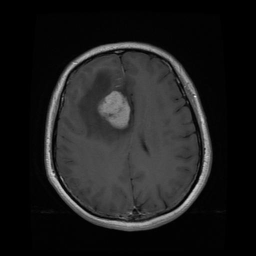

Generated mask:


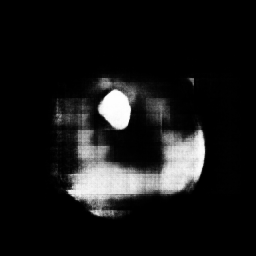

Mask overlay (image + mask):


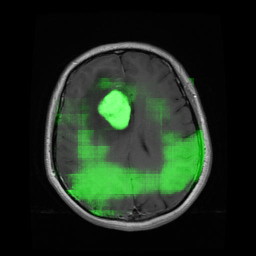

GradCAM heatmap:


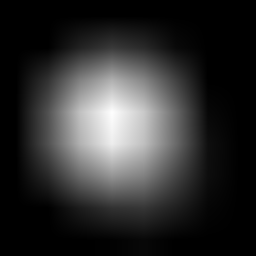

GradCAM overlay (image + gradcam):


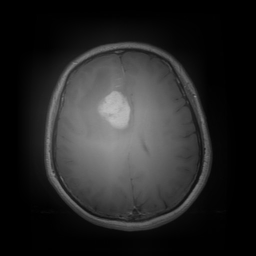


--- Classification result ---

pred_class,meningioma
confidence,0.8832

All outputs saved in: /content/pipeline_out


In [7]:
# Colab cell: run pipeline, create overlays, show images, print classification + special message
from google.colab import files
from IPython.display import Image, display
import cv2, numpy as np, os, json

# -------- CONFIG (change if needed) --------
SEG_MODEL = "/content/BTresunetmodel.pth"
CLF_MODEL = "/content/resnet.pth"
OUT_DIR = "/content/pipeline_out"
IMG_SIZE = 256
PIPE_SCRIPT = "/content/run_seg_then_classify.py"
# -------------------------------------------

# FIX: Modify run_seg_then_classify.py to handle PyTorch's weights_only default, state_dict key, and detach for numpy
try:
    with open(PIPE_SCRIPT, 'r') as f:
        lines = f.readlines()

    modified_load_args = False
    modified_state_dict_key = False
    modified_detach_numpy = False

    for i, line in enumerate(lines):
        # Patch for weights_only=False in torch.load
        if "seg_state = torch.load(seg_model_path, map_location=device)" in line and "weights_only=False" not in line:
            lines[i] = line.replace(")", ", weights_only=False)")
            modified_load_args = True
        # Patch for extracting model_state_dict
        if "seg_model.load_state_dict(seg_state)" in line and "seg_state['model_state_dict']" not in line:
            lines[i] = line.replace("seg_state)", "seg_state['model_state_dict'])")
            modified_state_dict_key = True
        # Patch for detach().numpy() in GradCAM
        if "cam = (weights * activ).sum(dim=0).cpu().numpy()" in line and ".detach().numpy()" not in line:
            lines[i] = line.replace(".numpy()", ".detach().numpy()")
            modified_detach_numpy = True

    if modified_load_args or modified_state_dict_key or modified_detach_numpy:
        with open(PIPE_SCRIPT, 'w') as f:
            f.writelines(lines)
        print(f"Successfully patched {PIPE_SCRIPT} for model loading and GradCAM compatibility.")
    else:
        print(f"{PIPE_SCRIPT} already patched or lines not found for modification.")

except FileNotFoundError:
    print(f"Error: {PIPE_SCRIPT} not found. Please ensure it's in the /content/ directory.")
except Exception as e:
    print(f"An error occurred while patching {PIPE_SCRIPT}: {e}")

# 1) Upload image
print("Upload one image file (JPG/PNG)...")
uploaded = files.upload()
img_path = next(iter(uploaded.keys()))
print("Uploaded:", img_path)

# 2) Run pipeline script (segmentation -> gradcam -> classifier)
print("\nRunning pipeline...")
!python "{PIPE_SCRIPT}" --image "{img_path}" --seg-model "{SEG_MODEL}" --clf-model "{CLF_MODEL}" --out-dir "{OUT_DIR}" --img-size {IMG_SIZE}

# 3) Paths to pipeline outputs (expected)
input_resized = os.path.join(OUT_DIR, "input_resized.png")
pred_mask = os.path.join(OUT_DIR, "pred_mask.png")
gradcam = os.path.join(OUT_DIR, "gradcam.png")
stacked = os.path.join(OUT_DIR, "stacked_input.png")
result_txt = os.path.join(OUT_DIR, "result.txt")

# Quick check
for p in [input_resized, pred_mask, gradcam, result_txt]:
    print(p, "->", "FOUND" if os.path.exists(p) else "MISSING")

# 4) Helper: create overlay (image + mask) and (image + gradcam)
def make_mask_overlay(img_path, mask_path, out_path, alpha=0.6, mask_color=(0,255,0)):
    # Read image (resized) and mask (grayscale 0..1 or 0..255)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        # build empty mask
        mask = np.zeros_like(img, dtype=np.uint8)
    # normalize mask to 0..1
    if mask.max() > 1:
        mask_n = (mask.astype(float) / 255.0)
    else:
        mask_n = mask.astype(float)
    mask_n = np.clip(mask_n, 0.0, 1.0)
    # colorize mask
    colored = np.zeros_like(img_rgb)
    colored[:,:,0] = (mask_n * mask_color[2]).astype(np.uint8)  # B
    colored[:,:,1] = (mask_n * mask_color[1]).astype(np.uint8)  # G
    colored[:,:,2] = (mask_n * mask_color[0]).astype(np.uint8)  # R
    # overlay
    overlay = cv2.addWeighted(img_rgb.astype(float), 1.0, colored.astype(float), alpha, 0.0)
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)
    cv2.imwrite(out_path, overlay[:,:,::-1])  # save as RGB ordering (cv2 uses BGR)
    return out_path

def make_gradcam_overlay(img_path, gradcam_path, out_path, alpha=0.5):
    # img: grayscale, gradcam: colored or grayscale normalized 0..1 or colored image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    # load gradcam; it may already be a colored jet map or grayscale
    g = cv2.imread(gradcam_path)
    if g is None:
        # if gradcam missing, build empty
        g = np.zeros_like(img_rgb)
    else:
        # if gradcam has 3 channels (BGR), resize to match
        g = cv2.resize(g, (img_rgb.shape[1], img_rgb.shape[0]))
    # blend: convert both to float and blend
    overlay = cv2.addWeighted(img_rgb.astype(float), 1.0 - alpha, g.astype(float), alpha, 0.0)
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)
    cv2.imwrite(out_path, overlay[:,:,::-1])
    return out_path

# Ensure out dir exists
os.makedirs(OUT_DIR, exist_ok=True)

# produce overlays
mask_overlay_path = os.path.join(OUT_DIR, "mask_overlay.png")
gradcam_overlay_path = os.path.join(OUT_DIR, "gradcam_overlay.png")

try:
    make_mask_overlay(input_resized, pred_mask, mask_overlay_path, alpha=0.6, mask_color=(0,255,0))
    print("Saved mask overlay ->", mask_overlay_path)
except Exception as e:
    print("Failed to create mask overlay:", e)

try:
    make_gradcam_overlay(input_resized, gradcam, gradcam_overlay_path, alpha=0.5)
    print("Saved gradcam overlay ->", gradcam_overlay_path)
except Exception as e:
    print("Failed to create gradcam overlay:", e)

# 5) Display outputs: (original resized, mask, mask_overlay, gradcam, gradcam_overlay)
print("\n--- Visual outputs ---\n")
display(Image(input_resized))
print("Generated mask:")
display(Image(pred_mask))
print("Mask overlay (image + mask):")
display(Image(mask_overlay_path))
print("GradCAM heatmap:")
display(Image(gradcam))
print("GradCAM overlay (image + gradcam):")
display(Image(gradcam_overlay_path))

# 6) Read & print classification result, with special message for no_tumor
print("\n--- Classification result ---\n")
if os.path.exists(result_txt):
    with open(result_txt, "r") as f:
        txt = f.read().strip()
    print(txt)
    # try to parse predicted class name
    # result.txt format from pipeline: lines like "pred_label,1" "pred_class,Meningioma" "confidence,0.92"
    pred_class = None
    for line in txt.splitlines():
        parts = line.split(",")
        if len(parts) >= 2 and parts[0].strip().lower().startswith("pred_class"):
            pred_class = parts[1].strip().lower()
    if pred_class is not None:
        # normalize common variants
        norm = pred_class.replace(" ", "").replace("-", "")
        if norm in ("no_tumor", "no_tumour", "no_tumor"):
            print("\ncongrats on no tumor")
else:
    print("result.txt not found in output dir. Check pipeline logs.")

print("\nAll outputs saved in:", OUT_DIR)


In [ ]:
!python /content/run_seg_then_classify.py \
  --image "/content/your_image.jpg" \
  --seg-model "/content/BTresunetmodel.pth" \
  --clf-model "/content/resnet.pth" \
  --out-dir "/content/pipeline_out"